In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import psycopg2

def connect_to_postgres(host, port, database, user, password):
    try:
        # Connect to the PostgreSQL database
        connection = psycopg2.connect(
            host=host, port=port, database=database, user=user, password=password
        )
        print("Connected to PostgreSQL database successfully!")
        return connection
    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", error)
        return None


# Provide your PostgreSQL connection details
host = "localhost"
port = "5432"
database = "postgres"
user = "postgres"
password = "Root@123"

# Connect to the PostgreSQL database
connection = connect_to_postgres(host, port, database, user, password)

# Check if connection is successful before proceeding further
if connection:
    # Add your code here to perform tasks on the database
    pass

Connected to PostgreSQL database successfully!


In [3]:
def fetch_data(connection, query):
    try:
        # Create a cursor object using the connection
        cursor = connection.cursor()

        # Execute the query
        cursor.execute(query)

        # Fetch all the rows
        data = cursor.fetchall()

        # Get the column names
        columns = [desc[0] for desc in cursor.description]

        # Create a DataFrame using the fetched data and column names
        df = pd.DataFrame(data, columns=columns)

        # Close the cursor
        cursor.close()

        return df
    except (Exception, psycopg2.Error) as error:
        print("Error fetching data from PostgreSQL:", error)
        return None


# Define the SQL query to retrieve relevant columns from the xdr_data table
query = """
    SELECT *
    FROM public.xdr_data
"""

# Fetch the data from the database
xdr_data = fetch_data(connection, query)

# Display the first few rows of the fetched data
print(xdr_data.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting relevant features for clustering
features = [
    "Avg RTT DL (ms)",
    "Avg RTT UL (ms)",
    "Avg Bearer TP DL (kbps)",
    "Avg Bearer TP UL (kbps)",
    "TCP DL Retrans. Vol (Bytes)",
    "TCP UL Retrans. Vol (Bytes)",
    "Activity Duration DL (ms)",
    "Activity Duration UL (ms)",
    "Total UL (Bytes)",
    "Total DL (Bytes)",
]

# Dropping rows with missing values
xdr_data.dropna(subset=features, inplace=True)

# Standardizing the features
scaler = StandardScaler()
xdr_data_scaled = scaler.fit_transform(xdr_data[features])

In [5]:
# Performing k-means clustering with k=2 for engagement
kmeans_engagement = KMeans(n_clusters=2, random_state=42)
xdr_data["Engagement Cluster"] = kmeans_engagement.fit_predict(xdr_data_scaled)

# Performing k-means clustering with k=2 for experience
kmeans_experience = KMeans(n_clusters=2, random_state=42)
xdr_data["Experience Cluster"] = kmeans_experience.fit_predict(xdr_data_scaled)

# Calculate engagement scores
engagement_centroids = kmeans_engagement.cluster_centers_
engagement_distances = np.linalg.norm(
    xdr_data_scaled - engagement_centroids[xdr_data["Engagement Cluster"]], axis=1
)
xdr_data["Engagement Score"] = engagement_distances

# Calculate experience scores
experience_centroids = kmeans_experience.cluster_centers_
experience_distances = np.linalg.norm(
    xdr_data_scaled - experience_centroids[xdr_data["Experience Cluster"]], axis=1
)
xdr_data["Experience Score"] = experience_distances

# Display the first few rows of the DataFrame with scores
print(xdr_data[["MSISDN/Number", "Engagement Score", "Experience Score"]].head())

    MSISDN/Number  Engagement Score  Experience Score
9    3.365922e+10          2.575522          2.575522
11   3.366447e+10          0.889504          0.889504
14   3.365922e+10          1.540988          1.540988
15   3.375376e+10          2.886639          2.886639
20   3.365875e+10          1.735851          1.735851


In [17]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming xdr_data contains the DataFrame with Engagement Score and Experience Score columns
engagement_experience_data = xdr_data[["Engagement Score", "Experience Score"]].values

# Assuming you want to use 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(engagement_experience_data)

# Assuming you want to add cluster labels to the DataFrame
xdr_data["Cluster Label"] = cluster_labels

# Getting cluster centers
cluster_centers = kmeans.cluster_centers_

print("Cluster Labels:", cluster_labels)
print("Cluster Centers:", cluster_centers)

Cluster Labels: [0 0 0 ... 0 0 0]
Cluster Centers: [[ 2.10433401  2.10433401]
 [15.8619508  15.8619508 ]]


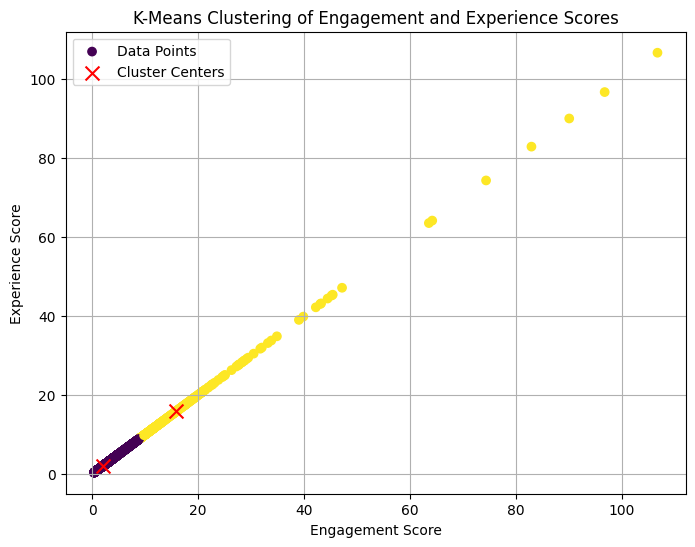

In [18]:
import matplotlib.pyplot as plt

# Extracting data points and cluster labels
engagement_scores = xdr_data["Engagement Score"]
experience_scores = xdr_data["Experience Score"]
cluster_labels = xdr_data["Cluster Label"]

# Extracting cluster centers
cluster_centers = kmeans.cluster_centers_

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(
    engagement_scores,
    experience_scores,
    c=cluster_labels,
    cmap="viridis",
    label="Data Points",
)
plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c="red",
    marker="x",
    s=100,
    label="Cluster Centers",
)
plt.xlabel("Engagement Score")
plt.ylabel("Experience Score")
plt.title("K-Means Clustering of Engagement and Experience Scores")
plt.legend()
plt.grid(True)
plt.show()

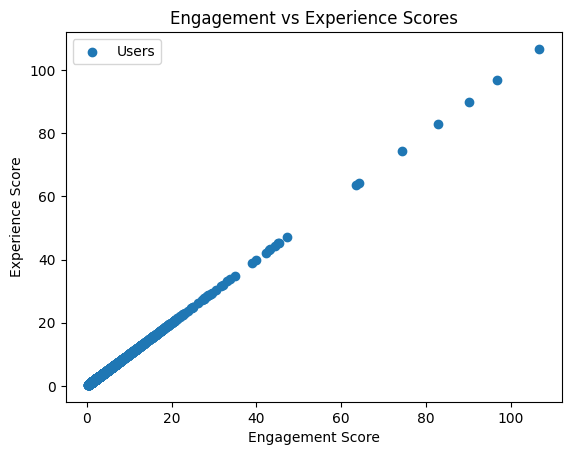

In [6]:
import matplotlib.pyplot as plt

# Extracting data
msisdn_numbers = xdr_data["MSISDN/Number"]
engagement_scores = xdr_data["Engagement Score"]
experience_scores = xdr_data["Experience Score"]

# Plotting engagement scores
plt.scatter(engagement_scores, experience_scores, label="Users")
plt.xlabel("Engagement Score")
plt.ylabel("Experience Score")
plt.title("Engagement vs Experience Scores")
plt.legend()
plt.show()

In [8]:
# Selecting relevant features and target variable
X = xdr_data[features]
y = xdr_data["Satisfaction Score"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

In [16]:
# Calculate satisfaction score
xdr_data["Satisfaction Score"] = (
    xdr_data["Engagement Score"] + xdr_data["Experience Score"]
) / 2

# Report the top 10 satisfied customers
top_satisfied_customers = xdr_data[["MSISDN/Number", "Satisfaction Score"]].nlargest(
    10, "Satisfaction Score"
)
print("Top 10 Satisfied Customers:")
print(top_satisfied_customers)


Top 10 Satisfied Customers:
        MSISDN/Number  Satisfaction Score
36203    3.366905e+10          106.716518
76641    3.365825e+10           96.748367
67308    3.376359e+10           90.057374
1505     3.366905e+10           82.925935
42107    3.376206e+10           74.358950
133265   3.366470e+10           64.190409
35138    3.366509e+10           63.559904
119183   3.365083e+10           47.170658
142220   3.376092e+10           45.409706
22851    3.376094e+10           45.199944


In [10]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.21115327656767424
R-squared: 0.9497705585774141


In [11]:
# Group by engagement cluster and calculate average satisfaction and experience scores
engagement_cluster_stats = xdr_data.groupby("Engagement Cluster").agg(
    {"Satisfaction Score": "mean", "Experience Score": "mean"}
)

# Group by experience cluster and calculate average satisfaction and experience scores
experience_cluster_stats = xdr_data.groupby("Experience Cluster").agg(
    {"Satisfaction Score": "mean", "Experience Score": "mean"}
)

print("Engagement Cluster Stats:")
print(engagement_cluster_stats)

print("\nExperience Cluster Stats:")
print(experience_cluster_stats)

Engagement Cluster Stats:
                    Satisfaction Score  Experience Score
Engagement Cluster                                      
0                             4.026023          4.026023
1                             2.034945          2.034945

Experience Cluster Stats:
                    Satisfaction Score  Experience Score
Experience Cluster                                      
0                             4.026023          4.026023
1                             2.034945          2.034945


In [20]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming xdr_data contains the DataFrame with Engagement Score and Experience Score columns
engagement_experience_data = xdr_data[["Engagement Score", "Experience Score"]].values

# Assuming you want to use 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(engagement_experience_data)

# Assuming you want to add cluster labels to the DataFrame
xdr_data["Cluster Label"] = cluster_labels

# Getting cluster centers
cluster_centers = kmeans.cluster_centers_

# Grouping data by cluster labels
cluster_grouped = xdr_data.groupby("Cluster Label")

# Calculating average satisfaction and experience scores per cluster
average_scores = cluster_grouped.agg(
    {"Satisfaction Score": "mean", "Experience Score": "mean"}
)

print("Average Satisfaction and Experience Scores per Cluster:")
print(average_scores)

Average Satisfaction and Experience Scores per Cluster:
               Satisfaction Score  Experience Score
Cluster Label                                      
0                        2.104334          2.104334
1                       15.861951         15.861951


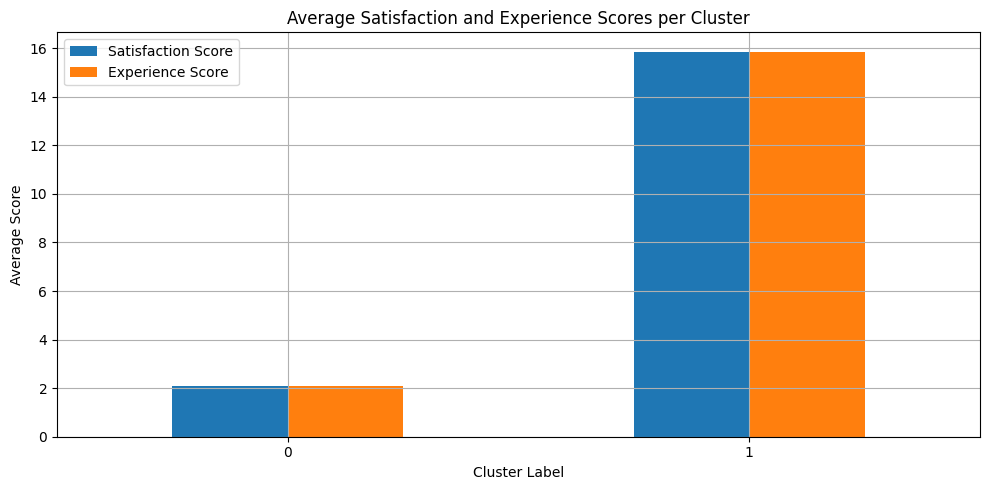

In [21]:
import matplotlib.pyplot as plt

# Assuming you have calculated average_scores DataFrame with columns: 'Satisfaction Score' and 'Experience Score'

# Plotting average satisfaction and experience scores per engagement cluster
plt.figure(figsize=(10, 5))
average_scores.plot(kind="bar", ax=plt.gca())
plt.xlabel("Cluster Label")
plt.ylabel("Average Score")
plt.title("Average Satisfaction and Experience Scores per Cluster")
plt.xticks(rotation=0)
plt.legend(["Satisfaction Score", "Experience Score"])
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Save engagement cluster stats to CSV
engagement_cluster_stats.to_csv("../data/engagement_cluster_stats.csv")

# Save experience cluster stats to CSV
experience_cluster_stats.to_csv("../data/experience_cluster_stats.csv")

print("Cluster statistics saved successfully.")

Cluster statistics saved successfully.
